In [2]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
#import weatherbench2 as wb
#import metpy
import copy
import wrf
import time
#from metpy.units import units
import cartopy.crs as ccrs
print('modules loaded')
import datetime
import glob
import datetime as dt
import seaborn as sns
import metpy
from metpy.units import units

modules loaded


In [2]:
figpath='/users/mfeldman/figs/'
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
dataset='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
#dataset='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
# dataset='gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
# dataset='gs://weatherbench2/datasets/keisler/2020-360x181.zarr'
# dataset='gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr'
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
#mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/'
model='graphcast_dawn'

In [3]:
#EVENT SELECTION ERA5
year=2020; month=(9,10,11,12,1,2)
latslice=slice(-40,-25); lonslice=slice(290,310)
lon_conv=False
flag='ARG'
# year=2020; month=np.arange(3,10); 
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude').sel(latitude=latslice,longitude=lonslice)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))
zsurf_c=xr_era5['geopotential_at_surface']


In [8]:
zsurf_c

<xarray.DataArray 'geopotential_at_surface' (latitude: 61, longitude: 81)>
[4941 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -40.0 -39.75 -39.5 ... -25.5 -25.25 -25.0
  * longitude  (longitude) float32 290.0 290.2 290.5 290.8 ... 309.5 309.8 310.0
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [4]:

plevel=copy.deepcopy(xr_era5.level.values)
        
xr_era5['pressure'] = (('level'), plevel)
plevel=xr_era5.pressure
#xr_dataset = xr_era5.assign_coords(level=np.arange(len(plevel)))
tlevel=xr_era5.temperature
qlevel=xr_era5.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_era5.geopotential
ulevel=xr_era5.u_component_of_wind
vlevel=xr_era5.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim



: 

In [4]:
pmsl=xr_era5.mean_sea_level_pressure
tsurf=xr_era5['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": tsurf.time}, axis=0)
zlevel=xr_era5.geopotential


In [5]:

psurf=pmsl * (tsurf/ (tsurf - (zsurf/9.81) * 0.0065))**(-1)

ps_era=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

NameError: name 'zlevel' is not defined

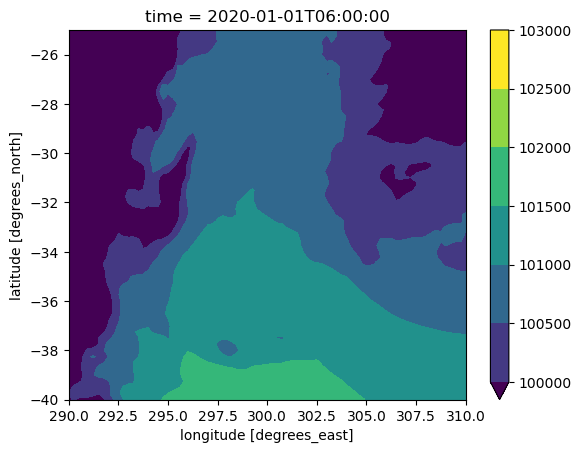

In [11]:
psurf.isel(time=1).plot.contourf(vmin=100000,vmax=103000)

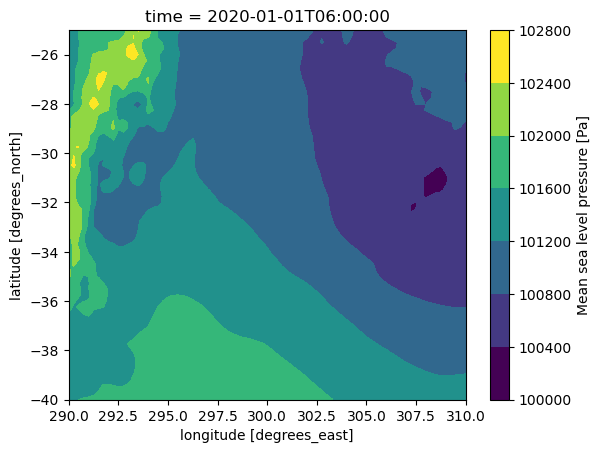

In [10]:
pmsl.isel(time=1).plot.contourf()

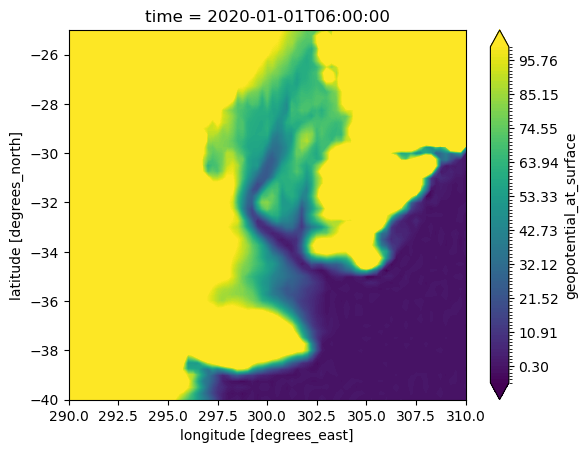

In [18]:
zs.isel(time=1).plot.contourf(vmin=-5,vmax=100,levels=100)

In [17]:
era_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps_era, ter_follow=False)
era_inst=era_inst.assign_coords(longitude=psurf.longitude.values);
era_inst=era_inst.assign_coords(latitude=psurf.latitude.values);
era_inst=era_inst.assign_coords(time=psurf.time.values)

In [ ]:
du_01=ulevel.sel(level=850)-xr_era5['10m_u_component_of_wind']; dv_01=vlevel.sel(level=850)-xr_era5['10m_v_component_of_wind']
du_03=ulevel.sel(level=700)-xr_era5['10m_u_component_of_wind']; dv_03=vlevel.sel(level=700)-xr_era5['10m_v_component_of_wind']
du_06=ulevel.sel(level=500)-xr_era5['10m_u_component_of_wind']; dv_06=vlevel.sel(level=500)-xr_era5['10m_v_component_of_wind']

bs_01=( du_01**2 + dv_01**2 )**0.5
bs_03=( du_03**2 + dv_03**2 )**0.5
bs_06=( du_06**2 + dv_06**2 )**0.5

du_01=du_01.to_dataset(name='du_01')
dv_01=dv_01.to_dataset(name='dv_01')
bs_01=bs_01.to_dataset(name='bs_01')
du_03=du_03.to_dataset(name='du_03')
dv_03=dv_03.to_dataset(name='dv_03')
bs_03=bs_03.to_dataset(name='bs_03')
du_06=du_06.to_dataset(name='du_06')
dv_06=dv_06.to_dataset(name='dv_06')
bs_06=bs_06.to_dataset(name='bs_06')

era_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')

xr_era5_rh = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr').sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))
xr_era5_rh=xr_era5_rh.sel(time=xr_era5_rh.time.dt.year.isin([year]))
xr_era5_rh=xr_era5_rh.sel(time=xr_era5_rh.time.dt.month.isin([month]))
xr_era5_rh.relative_humidity
rlevel=xr_era5_rh.relative_humidity
era_params['cape']=era_inst.sel(mcape_mcin_lcl_lfc='mcape')
era_params['cin']=era_inst.sel(mcape_mcin_lcl_lfc='mcin')
era_params['lcl']=era_inst.sel(mcape_mcin_lcl_lfc='lcl')
era_params['lfc']=era_inst.sel(mcape_mcin_lcl_lfc='lfc')
era_params['q500']=qlevel.sel(level=500)
era_params['r500']=rlevel.sel(level=500)
era_params['t500']=tlevel.sel(level=500)
era_params['q925']=qlevel.sel(level=925)
era_params['r925']=rlevel.sel(level=925)
era_params['t925']=tlevel.sel(level=925)
era_params = era_params.squeeze()
era_params = era_params.drop(['level','mcape_mcin_lcl_lfc'])

In [36]:
era_params.to_netcdf(mlpath+'USA_convseason_2020.nc')

In [74]:
# u_l=ulevel.fillna(0)
# v_l=vlevel.fillna(0)
# z_l=zl.fillna(0)
# z_s=zs.fillna(0)
# era_srh_03=wrf.srhel(u=u_l, v=v_l, height=z_l, terrain=z_s, top=3000.0)
# era_srh_06=wrf.srhel(u=u_l, v=v_l, height=z_l, terrain=z_s, top=6000.0)

In [ ]:
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
xr_model=xr.open_zarr(ifs_init).sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))
xr_init=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
xr_init=xr_init.sel(time=xr_init.time.dt.month.isin([month]))

print(xr_init.dims)

xr_init = xr_init.sortby('level', ascending=False)
plevel=copy.deepcopy(xr_init.level.values)
xr_init['pressure'] = (('level'), plevel)
plevel=xr_init.pressure
#xr_init = xr_init.assign_coords(level=np.arange(len(plevel)))

tlevel=xr_init.temperature
qlevel=xr_init.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_init.geopotential
ulevel=xr_init.u_component_of_wind
vlevel=xr_init.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim

psurf=xr_init.mean_sea_level_pressure
tsurf=xr_init['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

init_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
init_inst=init_inst.assign_coords(longitude=psurf.longitude.values);
init_inst=init_inst.assign_coords(latitude=psurf.latitude.values);
init_inst=init_inst.assign_coords(time=psurf.time.values)

In [ ]:
du_01=ulevel.sel(level=850)-xr_init['10m_u_component_of_wind']; dv_01=vlevel.sel(level=850)-xr_init['10m_v_component_of_wind']
du_03=ulevel.sel(level=700)-xr_init['10m_u_component_of_wind']; dv_03=vlevel.sel(level=700)-xr_init['10m_v_component_of_wind']
du_06=ulevel.sel(level=500)-xr_init['10m_u_component_of_wind']; dv_06=vlevel.sel(level=500)-xr_init['10m_v_component_of_wind']

bs_01=( du_01**2 + dv_01**2 )**0.5
bs_03=( du_03**2 + dv_03**2 )**0.5
bs_06=( du_06**2 + dv_06**2 )**0.5

du_01=du_01.to_dataset(name='du_01')
dv_01=dv_01.to_dataset(name='dv_01')
bs_01=bs_01.to_dataset(name='bs_01')
du_03=du_03.to_dataset(name='du_03')
dv_03=dv_03.to_dataset(name='dv_03')
bs_03=bs_03.to_dataset(name='bs_03')
du_06=du_06.to_dataset(name='du_06')
dv_06=dv_06.to_dataset(name='dv_06')
bs_06=bs_06.to_dataset(name='bs_06')

init_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')

init_params['cape']=init_inst.sel(mcape_mcin_lcl_lfc='mcape')
init_params['cin']=init_inst.sel(mcape_mcin_lcl_lfc='mcin')
init_params['lcl']=init_inst.sel(mcape_mcin_lcl_lfc='lcl')
init_params['lfc']=init_inst.sel(mcape_mcin_lcl_lfc='lfc')

In [ ]:
rlevel=metpy.calc.relative_humidity_from_specific_humidity(plevel_exp.values* units('hPa'), tlevel.values* units('K'), qlevel.values* units('kg/kg')).to('%').magnitude

In [43]:
r1level=copy.deepcopy(tlevel)
r1level.data=rlevel
init_params['q500']=qlevel.sel(level=500)
init_params['r500']=r1level.sel(level=500)
init_params['t500']=tlevel.sel(level=500)
init_params['q925']=qlevel.sel(level=925)
init_params['r925']=r1level.sel(level=925)
init_params['t925']=tlevel.sel(level=925)
init_params = init_params.squeeze()
init_params = init_params.drop(['level','mcape_mcin_lcl_lfc'])

init_params.to_netcdf(mlpath+'season_2020/USA_init_convseason_2020.nc.nc')

/tmp/ipykernel_81268/2487972960.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  init_params = init_params.drop(['level','mcape_mcin_lcl_lfc'])


In [6]:
#LOADING FORECAST DATASET
models=['pangu','pangu-oper','ifs']
latslice=slice(20,50); lonslice=slice(250,300);year=2020; month=np.arange(5,6); 
d1='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
d2='gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
d3='gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d4='gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d5='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
paths=[d1,d2,d5]


nn=1
dataset=paths[nn]
model=models[nn]
xr_model=xr.open_zarr(dataset).sortby('latitude').sel(latitude=latslice,longitude=lonslice)
xr_model=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
xr_model=xr_model.sel(time=xr_model.time.dt.month.isin([month]))


In [9]:
pmsl=xr_model.mean_sea_level_pressure.values[0,0,0,0]/100

In [10]:
pmsl

1013.6609375

In [ ]:

for t in xr_model.time:
        xr_dataset=xr_model.sel(time=t)
        fcst_init=xr_dataset.time
        init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
        #xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
        xr_dataset = xr_dataset.sortby('level', ascending=False)
        
        plevel=copy.deepcopy(xr_dataset.level.values)
        
        xr_dataset['pressure'] = (('level'), plevel)
        plevel=xr_dataset.pressure
        #xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
        
        tlevel=xr_dataset.temperature
        qlevel=xr_dataset.specific_humidity
        plevel_dim=np.ones([1,len(plevel),1,1])
        zlevel=xr_dataset.geopotential
        ulevel=xr_dataset.u_component_of_wind
        vlevel=xr_dataset.v_component_of_wind
        for n1 in range(len(plevel.data)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim
        
        psurf=xr_dataset.mean_sea_level_pressure
        tsurf=xr_dataset['2m_temperature']
        #zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        zsurf = zsurf_c.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=0)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
        mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
        mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
        mod_inst=mod_inst.assign_coords(time=psurf.time.values)

        du_01=ulevel.sel(level=850)-xr_dataset['10m_u_component_of_wind']; dv_01=vlevel.sel(level=850)-xr_dataset['10m_v_component_of_wind']
        du_03=ulevel.sel(level=700)-xr_dataset['10m_u_component_of_wind']; dv_03=vlevel.sel(level=700)-xr_dataset['10m_v_component_of_wind']
        du_06=ulevel.sel(level=500)-xr_dataset['10m_u_component_of_wind']; dv_06=vlevel.sel(level=500)-xr_dataset['10m_v_component_of_wind']
        
        bs_01=( du_01**2 + dv_01**2 )**0.5
        bs_03=( du_03**2 + dv_03**2 )**0.5
        bs_06=( du_06**2 + dv_06**2 )**0.5
        
        du_01=du_01.to_dataset(name='du_01')
        dv_01=dv_01.to_dataset(name='dv_01')
        bs_01=bs_01.to_dataset(name='bs_01')
        du_03=du_03.to_dataset(name='du_03')
        dv_03=dv_03.to_dataset(name='dv_03')
        bs_03=bs_03.to_dataset(name='bs_03')
        du_06=du_06.to_dataset(name='du_06')
        dv_06=dv_06.to_dataset(name='dv_06')
        bs_06=bs_06.to_dataset(name='bs_06')
        
        mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
        #mod_params=mod_params.squeeze(dim='level')
        mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
        mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
        mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
        mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
        rlevel=metpy.calc.relative_humidity_from_specific_humidity(plevel_exp.values* units('hPa'), tlevel.values* units('K'), qlevel.values* units('kg/kg')).to('%').magnitude
        r1level=copy.deepcopy(tlevel)
        r1level.data=rlevel
        mod_params['q500']=qlevel.sel(level=500)
        mod_params['r500']=r1level.sel(level=500)
        mod_params['t500']=tlevel.sel(level=500)
        mod_params['q925']=qlevel.sel(level=925)
        mod_params['r925']=r1level.sel(level=925)
        mod_params['t925']=tlevel.sel(level=925)
        mod_params = mod_params.squeeze()
        mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])
        
        
        mod_params.to_netcdf(mlpath+'season_2020/USA_conv_'+model+'_'+init+'.nc')

In [12]:
xr_dataset.latitude

<xarray.DataArray 'latitude' (latitude: 61)>
array([-40.  , -39.75, -39.5 , -39.25, -39.  , -38.75, -38.5 , -38.25, -38.  ,
       -37.75, -37.5 , -37.25, -37.  , -36.75, -36.5 , -36.25, -36.  , -35.75,
       -35.5 , -35.25, -35.  , -34.75, -34.5 , -34.25, -34.  , -33.75, -33.5 ,
       -33.25, -33.  , -32.75, -32.5 , -32.25, -32.  , -31.75, -31.5 , -31.25,
       -31.  , -30.75, -30.5 , -30.25, -30.  , -29.75, -29.5 , -29.25, -29.  ,
       -28.75, -28.5 , -28.25, -28.  , -27.75, -27.5 , -27.25, -27.  , -26.75,
       -26.5 , -26.25, -26.  , -25.75, -25.5 , -25.25, -25.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -40.0 -39.75 -39.5 ... -25.5 -25.25 -25.0

In [54]:


#LOADING FORECAST DATASET
models=['pangu','pangu-oper','ifs','graphcast','graphcast-oper']
s1=slice(50,20)
s2=slice(20,50)
d1='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
d2='gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
d3='gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d4='gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d5='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
paths=[d1,d2,d5]
slices=[s1,s1,s2]
for nn in range(len(models)):
    dataset=paths[nn]
    latslice=slices[nn]
    model=models[nn]
    if nn>2:
        xr_model=xr.open_zarr(dataset)
        xr_model=xr_model.rename({'lat': 'latitude','lon': 'longitude'})
        xr_model=xr_model.sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))
    else:    
        xr_model=xr.open_zarr(dataset).sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))
    xr_model=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
    xr_model=xr_model.sel(time=xr_model.time.dt.month.isin([month]))
    for t in xr_model.time:
        xr_dataset=xr_model.sel(time=t)
        fcst_init=xr_dataset.time
        init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
        #xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
        xr_dataset = xr_dataset.sortby('level', ascending=False)
        
        plevel=copy.deepcopy(xr_dataset.level.values)
        
        xr_dataset['pressure'] = (('level'), plevel)
        plevel=xr_dataset.pressure
        #xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
        
        tlevel=xr_dataset.temperature
        qlevel=xr_dataset.specific_humidity
        plevel_dim=np.ones([1,len(plevel),1,1])
        zlevel=xr_dataset.geopotential
        ulevel=xr_dataset.u_component_of_wind
        vlevel=xr_dataset.v_component_of_wind
        for n1 in range(len(plevel.data)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim
        
        psurf=xr_dataset.mean_sea_level_pressure
        tsurf=xr_dataset['2m_temperature']
        #zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        zsurf = zsurf_c.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=0)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
        mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
        mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
        mod_inst=mod_inst.assign_coords(time=psurf.time.values)

        du_01=ulevel.sel(level=850)-xr_dataset['10m_u_component_of_wind']; dv_01=vlevel.sel(level=850)-xr_dataset['10m_v_component_of_wind']
        du_03=ulevel.sel(level=700)-xr_dataset['10m_u_component_of_wind']; dv_03=vlevel.sel(level=700)-xr_dataset['10m_v_component_of_wind']
        du_06=ulevel.sel(level=500)-xr_dataset['10m_u_component_of_wind']; dv_06=vlevel.sel(level=500)-xr_dataset['10m_v_component_of_wind']
        
        bs_01=( du_01**2 + dv_01**2 )**0.5
        bs_03=( du_03**2 + dv_03**2 )**0.5
        bs_06=( du_06**2 + dv_06**2 )**0.5
        
        du_01=du_01.to_dataset(name='du_01')
        dv_01=dv_01.to_dataset(name='dv_01')
        bs_01=bs_01.to_dataset(name='bs_01')
        du_03=du_03.to_dataset(name='du_03')
        dv_03=dv_03.to_dataset(name='dv_03')
        bs_03=bs_03.to_dataset(name='bs_03')
        du_06=du_06.to_dataset(name='du_06')
        dv_06=dv_06.to_dataset(name='dv_06')
        bs_06=bs_06.to_dataset(name='bs_06')
        
        mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
        #mod_params=mod_params.squeeze(dim='level')
        mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
        mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
        mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
        mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
        rlevel=metpy.calc.relative_humidity_from_specific_humidity(plevel_exp.values* units('hPa'), tlevel.values* units('K'), qlevel.values* units('kg/kg')).to('%').magnitude
        r1level=copy.deepcopy(tlevel)
        r1level.data=rlevel
        mod_params['q500']=qlevel.sel(level=500)
        mod_params['r500']=r1level.sel(level=500)
        mod_params['t500']=tlevel.sel(level=500)
        mod_params['q925']=qlevel.sel(level=925)
        mod_params['r925']=r1level.sel(level=925)
        mod_params['t925']=tlevel.sel(level=925)
        mod_params = mod_params.squeeze()
        mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])
        
        
        mod_params.to_netcdf(mlpath+'season_2020/USA_conv_'+model+'_'+init+'.nc')
   

2020030100


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030112


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030200


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030212


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030300


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030312


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030400


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030412


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030500


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030512


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030600


/tmp/ipykernel_81268/382344507.py:95: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['level','mcape_mcin_lcl_lfc'])


2020030612


KeyboardInterrupt: 

In [55]:
import argparse as ap

In [40]:
start=xr_era5.time[0]
end=xr_era5.time[-1]

#LOADING FORECAST DATASET
models=['graphcast','graphcast-oper']
s1=slice(50,20)
s2=slice(20,50)
d1='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
d2='gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
d3='gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d4='gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d5='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
paths=[d3,d4]
slices=[s2,s2]
for nn in range(len(models)):
    dataset=paths[nn]
    latslice=slices[nn]
    model=models[nn]
    l1=850#[30,10][nn]
    l2=700#[25,9][nn]
    l3=500#[21,7][nn]
    hours=[0,12]
    for d in days[:]:
        for hour in hours[:]:
            xr_model=xr.open_zarr(dataset)
            xr_dataset=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([month]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([d]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([hour]),lat=latslice,lon=slice(250,300))
            fcst_init=xr_dataset.time[0]
            init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
            xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
            xr_dataset = xr_dataset.sel(level=xr_era5.level)
            xr_dataset = xr_dataset.sortby('level', ascending=False)
            
            plevel=copy.deepcopy(xr_dataset.level.values)
            
            xr_dataset['pressure'] = (('level'), plevel)
            plevel=xr_dataset.pressure
            #xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
            
            tlevel=xr_dataset.temperature
            qlevel=xr_dataset.specific_humidity
            plevel_dim=np.ones([1,len(plevel),1,1])
            zlevel=xr_dataset.geopotential
            ulevel=xr_dataset.u_component_of_wind
            vlevel=xr_dataset.v_component_of_wind
            for n1 in range(len(plevel.data)):
                plevel_dim[0,n1,0,0]=plevel[n1]
            plevel_exp=(tlevel/tlevel)*plevel_dim
            
            psurf=xr_dataset.mean_sea_level_pressure
            tsurf=xr_dataset['2m_temperature']
            zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
            zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
            
            ps=psurf/100
            zs=zsurf/9.81
            zl=zlevel/9.81
    
            mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
            mod_inst=mod_inst.assign_coords(lon=psurf.lon.values);
            mod_inst=mod_inst.assign_coords(lat=psurf.lat.values);
            mod_inst=mod_inst.assign_coords(time=psurf.time.values)
    
            du_01=ulevel.sel(level=l1)-xr_dataset['10m_u_component_of_wind']; dv_01=vlevel.sel(level=l1)-xr_dataset['10m_v_component_of_wind']
            du_03=ulevel.sel(level=l2)-xr_dataset['10m_u_component_of_wind']; dv_03=vlevel.sel(level=l2)-xr_dataset['10m_v_component_of_wind']
            du_06=ulevel.sel(level=l3)-xr_dataset['10m_u_component_of_wind']; dv_06=vlevel.sel(level=l3)-xr_dataset['10m_v_component_of_wind']
            
            bs_01=( du_01**2 + dv_01**2 )**0.5
            bs_03=( du_03**2 + dv_03**2 )**0.5
            bs_06=( du_06**2 + dv_06**2 )**0.5
            
            du_01=du_01.to_dataset(name='du_01')
            dv_01=dv_01.to_dataset(name='dv_01')
            bs_01=bs_01.to_dataset(name='bs_01')
            du_03=du_03.to_dataset(name='du_03')
            dv_03=dv_03.to_dataset(name='dv_03')
            bs_03=bs_03.to_dataset(name='bs_03')
            du_06=du_06.to_dataset(name='du_06')
            dv_06=dv_06.to_dataset(name='dv_06')
            bs_06=bs_06.to_dataset(name='bs_06')
            
            mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
            #mod_params=mod_params.squeeze(dim='level')
            mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
            mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
            mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
            mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
            
            mod_params.to_netcdf(mlpath+'USA_tor_2020_'+model+'_'+init+'.nc')

2020041100
2020041112
2020041000
2020041012
2020040900
2020040912
2020040800
2020040812
2020040700
2020040712
2020040600
2020040612
2020040500
2020040512
2020040400
2020040412
2020040300
2020040312
2020041100
2020041112
2020041000
2020041012
2020040900
2020040912
2020040800
2020040812
2020040700
2020040712
2020040600
2020040612
2020040500
2020040512
2020040400
2020040412
2020040300
2020040312


In [39]:
nn=0
dataset=paths[nn]
latslice=slices[nn]
model=models[nn]
l1=[29,10][nn]
l2=[25,9][nn]
l3=[21,7][nn]
hours=[0,12]
xr_model=xr.open_zarr(dataset)
ulevel.level
print(xr_model.sel(level=xr_era5.level))
xr_model=xr_model.sel(level=xr_era5.level)
xr_model.sel(level=500)

<xarray.Dataset>
Dimensions:                   (time: 886, prediction_timedelta: 40, lat: 721,
                               lon: 1440, level: 13)
Coordinates:
  * lat                       (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
  * level                     (level) int64 50 100 150 200 ... 700 850 925 1000
  * lon                       (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2019-11-16 ... 2021-01-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, lat, lon) float32 ...
    10m_v_component_of_wind   (time, prediction_timedelta, lat, lon) float32 ...
    10m_wind_speed            (time, prediction_timedelta, lat, lon) float32 ...
    2m_temperature            (time, prediction_timedelta, lat, lon) float32 ...
    geopotential              (time, prediction_timedelta, level, lat, lon) float32 ...
    

<xarray.Dataset>
Dimensions:                   (time: 886, prediction_timedelta: 40, lat: 721,
                               lon: 1440)
Coordinates:
  * lat                       (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
    level                     int64 500
  * lon                       (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2019-11-16 ... 2021-01-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, lat, lon) float32 ...
    10m_v_component_of_wind   (time, prediction_timedelta, lat, lon) float32 ...
    10m_wind_speed            (time, prediction_timedelta, lat, lon) float32 ...
    2m_temperature            (time, prediction_timedelta, lat, lon) float32 ...
    geopotential              (time, prediction_timedelta, lat, lon) float32 ...
    mean_sea_level_pressure   (time, prediction_timedelta, lat, lon) float32 ...
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, lat, lon) float32 ...
    total_precipitation_6hr   (time, prediction_timedelta, lat, lon) float32 ...
    u_component_of_wind       (time, prediction_timedelta, lat, lon) float32 ...
    v_component_of_wind       (time, prediction_timedelta, lat, lon) float32 ...
    vertical_velocity         (time, prediction_timedelta, lat, lon) float32 ...
    wind_speed                (time, prediction_timedelta, lat, lon) float32 ...

In [19]:
import netCDF4 as nc
import metpy
from metpy.units import units
start=xr_era5.time[0]
end=xr_era5.time[-1]
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
#mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/'
mname='fourcastnetv2'
#ref_cape=init_cape; ref_srh=init_srh
#LOADING FORECAST DATASET
model='fcnv2_dawn'
latslice=slice(50,20)
latslice2=slice(20,50)
year=2020; month=4
days=[7,8,9,10,11,12]
hours=[0,12]
#ref_cape=init_cape; ref_srh=init_srh
#ref_cape=era_cape.sel(latitude=latslice,longitude=slice(250,300)); ref_srh=era_srh.sel(latitude=latslice,longitude=slice(250,300))
for day in days[:]:
    for hour in hours[:]:
        myfile=sorted(glob.glob(mlpath+'*'+mname+'*'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'T'+str(hour).zfill(2)+'*'))[-1]
        #print(filelist)
        st=datetime.datetime(start.dt.year.values,start.dt.month.values,start.dt.day.values,start.dt.hour.values)
        et=datetime.datetime(end.dt.year.values,end.dt.month.values,end.dt.day.values,end.dt.hour.values)
        dat=datetime.datetime(year, month, day, hour)
        init=dat.strftime('%Y%m%d%H')
        lt1=int((st-dat).total_seconds() / 3600)#,tzinfo=datetime.timezone.utc)
        lt2=int((et-dat).total_seconds() / 3600)
        lt=np.arange(lt1,lt2+1,6).astype(str)
        print(lt)
        # myfile=[file for file in filelist if lt[0]+'_6.nc' in file][0]#any(part in file for part in lt)]
        print(myfile)
        xr_model=xr.open_dataset(myfile)
        xr_model=xr_model.rename({'lat':'latitude'})
        xr_model=xr_model.rename({'lon':'longitude'})
        xr_model=xr_model.squeeze(dim='history')
        xr_model=xr_model.sel(time=slice(start,end))
        xr_model=xr_model.sel(latitude=latslice,longitude=slice(250,300))
        plevel=[50,100,150,200,250,300,400,500,600,700,850,925,1000]
        ulevel = xr_model['__xarray_dataarray_variable__'][:,8:21,:]
        vlevel = xr_model['__xarray_dataarray_variable__'][:,21:34,:]
        zlevel = xr_model['__xarray_dataarray_variable__'][:,34:47,:]
        tlevel = xr_model['__xarray_dataarray_variable__'][:,47:60,:]
        rlevel = xr_model['__xarray_dataarray_variable__'][:,60:73,:]
        psurf = xr_model['__xarray_dataarray_variable__'][:,5,:]
        tsurf = xr_model['__xarray_dataarray_variable__'][:,4,:]
        usurf = xr_model['__xarray_dataarray_variable__'][:,0,:]
        vsurf = xr_model['__xarray_dataarray_variable__'][:,1,:]

        plevel_dim=np.ones([1,len(plevel),1,1])
        for n1 in range(len(plevel)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim
        
        dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
        qlevel=metpy.calc.specific_humidity_from_dewpoint(plevel_exp.values* units('hPa'), dplevel).magnitude
        #.to(units('kg/kg')#.magnitude

        zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        zsurf=zsurf.sel(latitude=latslice,longitude=slice(250,300))
        
        #zsurf = zsurf_c.expand_dims(dim={"history": psurf.history}, axis=1)
        #zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)
        #srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

        cape=cape.assign_coords(longitude=psurf.longitude.values);
        cape=cape.assign_coords(latitude=psurf.latitude.values);
        cape=cape.assign_coords(time=psurf.time.values)
        mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
        mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
        mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
        mod_inst=mod_inst.assign_coords(time=psurf.time.values)

        du_01=ulevel[:,10,:,:]-usurf; dv_01=vlevel[:,10,:,:]-vsurf
        du_03=ulevel[:,9,:,:]-usurf; dv_03=vlevel[:,9,:,:]-vsurf
        du_06=ulevel[:,7,:,:]-usurf; dv_06=vlevel[:,7,:,:]-vsurf
        
        bs_01=( du_01**2 + dv_01**2 )**0.5
        bs_03=( du_03**2 + dv_03**2 )**0.5
        bs_06=( du_06**2 + dv_06**2 )**0.5
        
        du_01=du_01.to_dataset(name='du_01')
        dv_01=dv_01.to_dataset(name='dv_01')
        bs_01=bs_01.to_dataset(name='bs_01')
        du_03=du_03.to_dataset(name='du_03')
        dv_03=dv_03.to_dataset(name='dv_03')
        bs_03=bs_03.to_dataset(name='bs_03')
        du_06=du_06.to_dataset(name='du_06')
        dv_06=dv_06.to_dataset(name='dv_06')
        bs_06=bs_06.to_dataset(name='bs_06')
        
        mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
        #mod_params=mod_params.squeeze(dim='level')
        mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
        mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
        mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
        mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
        
        mod_params.to_netcdf(mlpath+'USA_tor_2020_'+model+'_'+init+'.nc')

['120' '126' '132' '138' '144' '150' '156' '162']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-07T00_to_2020-04-14T00_ldt_168_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['108' '114' '120' '126' '132' '138' '144' '150']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-07T12_to_2020-04-14T12_ldt_168_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['96' '102' '108' '114' '120' '126' '132' '138']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-08T00_to_2020-04-14T12_ldt_156_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['84' '90' '96' '102' '108' '114' '120' '126']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-08T12_to_2020-04-14T12_ldt_144_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['72' '78' '84' '90' '96' '102' '108' '114']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-09T00_to_2020-04-14T12_ldt_132_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['60' '66' '72' '78' '84' '90' '96' '102']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-09T12_to_2020-04-14T12_ldt_120_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['48' '54' '60' '66' '72' '78' '84' '90']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-10T00_to_2020-04-14T12_ldt_108_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1397: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


['36' '42' '48' '54' '60' '66' '72' '78']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-10T12_to_2020-04-14T12_ldt_96_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['24' '30' '36' '42' '48' '54' '60' '66']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-11T00_to_2020-04-14T12_ldt_84_6.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


['12' '18' '24' '30' '36' '42' '48' '54']
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/fourcastnetv2_2020-04-11T12_to_2020-04-14T12_ldt_72_6.nc


KeyboardInterrupt: 

In [21]:
#FOURCASTNET
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020/'
year=2020; month=np.arange(3,10); 
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))
zsurf_c=xr_era5['geopotential_at_surface']
#LOADING FORECAST DATASET
models=['sfno','sfno-oper']
model=models[nn]
s1=slice(50,20)
s2=slice(20,50)
path='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/'
files=[]
months=['03','04','05','06','07','08','09']
for month in months: files+=sorted(glob.glob(path+'*2020-'+month+'*T00_to*.nc')+glob.glob(path+'*2020-'+month+'*T12_to*.nc'))

for file in files[:1]:
    xr_model=xr.open_dataset(file)
    strfind1=file.find('fcnv2_')+len('fcnv2_')
    strfind2=file.find('_to')
    init=file[strfind1:strfind2].replace('-','').replace('T','')
    xr_model=xr_model.rename({'lat':'latitude'})
    xr_model=xr_model.rename({'lon':'longitude'})
    xr_model=xr_model.rename({'time':'prediction_timedelta'})
    #xr_model=xr_model.squeeze(dim='history')
    xr_model=xr_model.sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))
    plevel=[50,100,150,200,250,300,400,500,600,700,850,925,1000]
    ulevel = xr_model.u #xr_model['__xarray_dataarray_variable__'][:,8:21,:]
    vlevel = xr_model.v #['__xarray_dataarray_variable__'][:,21:34,:]
    zlevel = xr_model.z #['__xarray_dataarray_variable__'][:,34:47,:]
    tlevel = xr_model.t #['__xarray_dataarray_variable__'][:,47:60,:]
    rlevel = xr_model.r #['__xarray_dataarray_variable__'][:,60:73,:]
    psurf = xr_model.sp #['__xarray_dataarray_variable__'][:,5,:]
    tsurf = xr_model.t2m #['__xarray_dataarray_variable__'][:,4,:]
    usurf = xr_model.u10 #['__xarray_dataarray_variable__'][:,0,:]
    vsurf = xr_model.v10 #['__xarray_dataarray_variable__'][:,1,:]

    plevel_dim=np.ones([1,len(plevel),1,1])
    for n1 in range(len(plevel)):
        plevel_dim[0,n1,0,0]=plevel[n1]
    plevel_exp=(tlevel/tlevel)*plevel_dim
    
    dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
    qlevel=metpy.calc.specific_humidity_from_dewpoint(plevel_exp.values* units('hPa'), dplevel).magnitude
    #.to(units('kg/kg')#.magnitude

    zsurf = zsurf_c.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=0)
    #zsurf=zsurf.sel(latitude=latslice,longitude=slice(250,300))
    
    #zsurf = zsurf_c.expand_dims(dim={"history": psurf.history}, axis=1)
    #zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
    
    ps=psurf/100
    zs=zsurf/9.81
    zl=zlevel/9.81

    mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
    mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
    mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
    mod_inst=mod_inst.assign_coords(prediction_timedelta=psurf.prediction_timedelta.values)

    du_01=ulevel[:,10,:,:]-usurf; dv_01=vlevel[:,10,:,:]-vsurf
    du_03=ulevel[:,9,:,:]-usurf; dv_03=vlevel[:,9,:,:]-vsurf
    du_06=ulevel[:,7,:,:]-usurf; dv_06=vlevel[:,7,:,:]-vsurf
    
    bs_01=( du_01**2 + dv_01**2 )**0.5
    bs_03=( du_03**2 + dv_03**2 )**0.5
    bs_06=( du_06**2 + dv_06**2 )**0.5
    
    du_01=du_01.to_dataset(name='du_01')
    dv_01=dv_01.to_dataset(name='dv_01')
    bs_01=bs_01.to_dataset(name='bs_01')
    du_03=du_03.to_dataset(name='du_03')
    dv_03=dv_03.to_dataset(name='dv_03')
    bs_03=bs_03.to_dataset(name='bs_03')
    du_06=du_06.to_dataset(name='du_06')
    dv_06=dv_06.to_dataset(name='dv_06')
    bs_06=bs_06.to_dataset(name='bs_06')
    
    mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
    #mod_params=mod_params.squeeze(dim='level')
    mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
    mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
    mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
    mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
    q1level=copy.deepcopy(tlevel)
    q1level.data=qlevel
    mod_params['q500']=q1level[:,7,:,:]
    mod_params['r500']=rlevel[:,7,:,:]
    mod_params['t500']=tlevel[:,7,:,:]
    mod_params['q925']=q1level[:,11,:,:]
    mod_params['r925']=rlevel[:,11,:,:]
    mod_params['t925']=tlevel[:,11,:,:]
    mod_params = mod_params.squeeze()
    mod_params = mod_params.drop(['mcape_mcin_lcl_lfc'])
    
    
    mod_params.to_netcdf(mlpath+'USA_conv_'+model+'_'+init+'.nc')

/tmp/ipykernel_3949053/987700028.py:45: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/tmp/ipykernel_3949053/987700028.py:97: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params = mod_params.drop(['mcape_mcin_lcl_lfc'])


In [5]:
xr_model=xr.open_dataset(file)
strfind1=file.find('fcnv2_')+len('fcnv2_')
strfind2=file.find('_to')
init=file[strfind1:strfind2].replace('-','').replace('T','')

In [8]:
    xr_model=xr_model.rename({'lat':'latitude'})
    xr_model=xr_model.rename({'lon':'longitude'})
    #xr_model=xr_model.rename({'time':'prediction_timedelta'})
    #xr_model=xr_model.squeeze(dim='history')
    xr_model=xr_model.sortby('latitude').sel(latitude=slice(20,50),longitude=slice(250,300))

/tmp/ipykernel_3949053/2727769030.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in a.axes.flat:


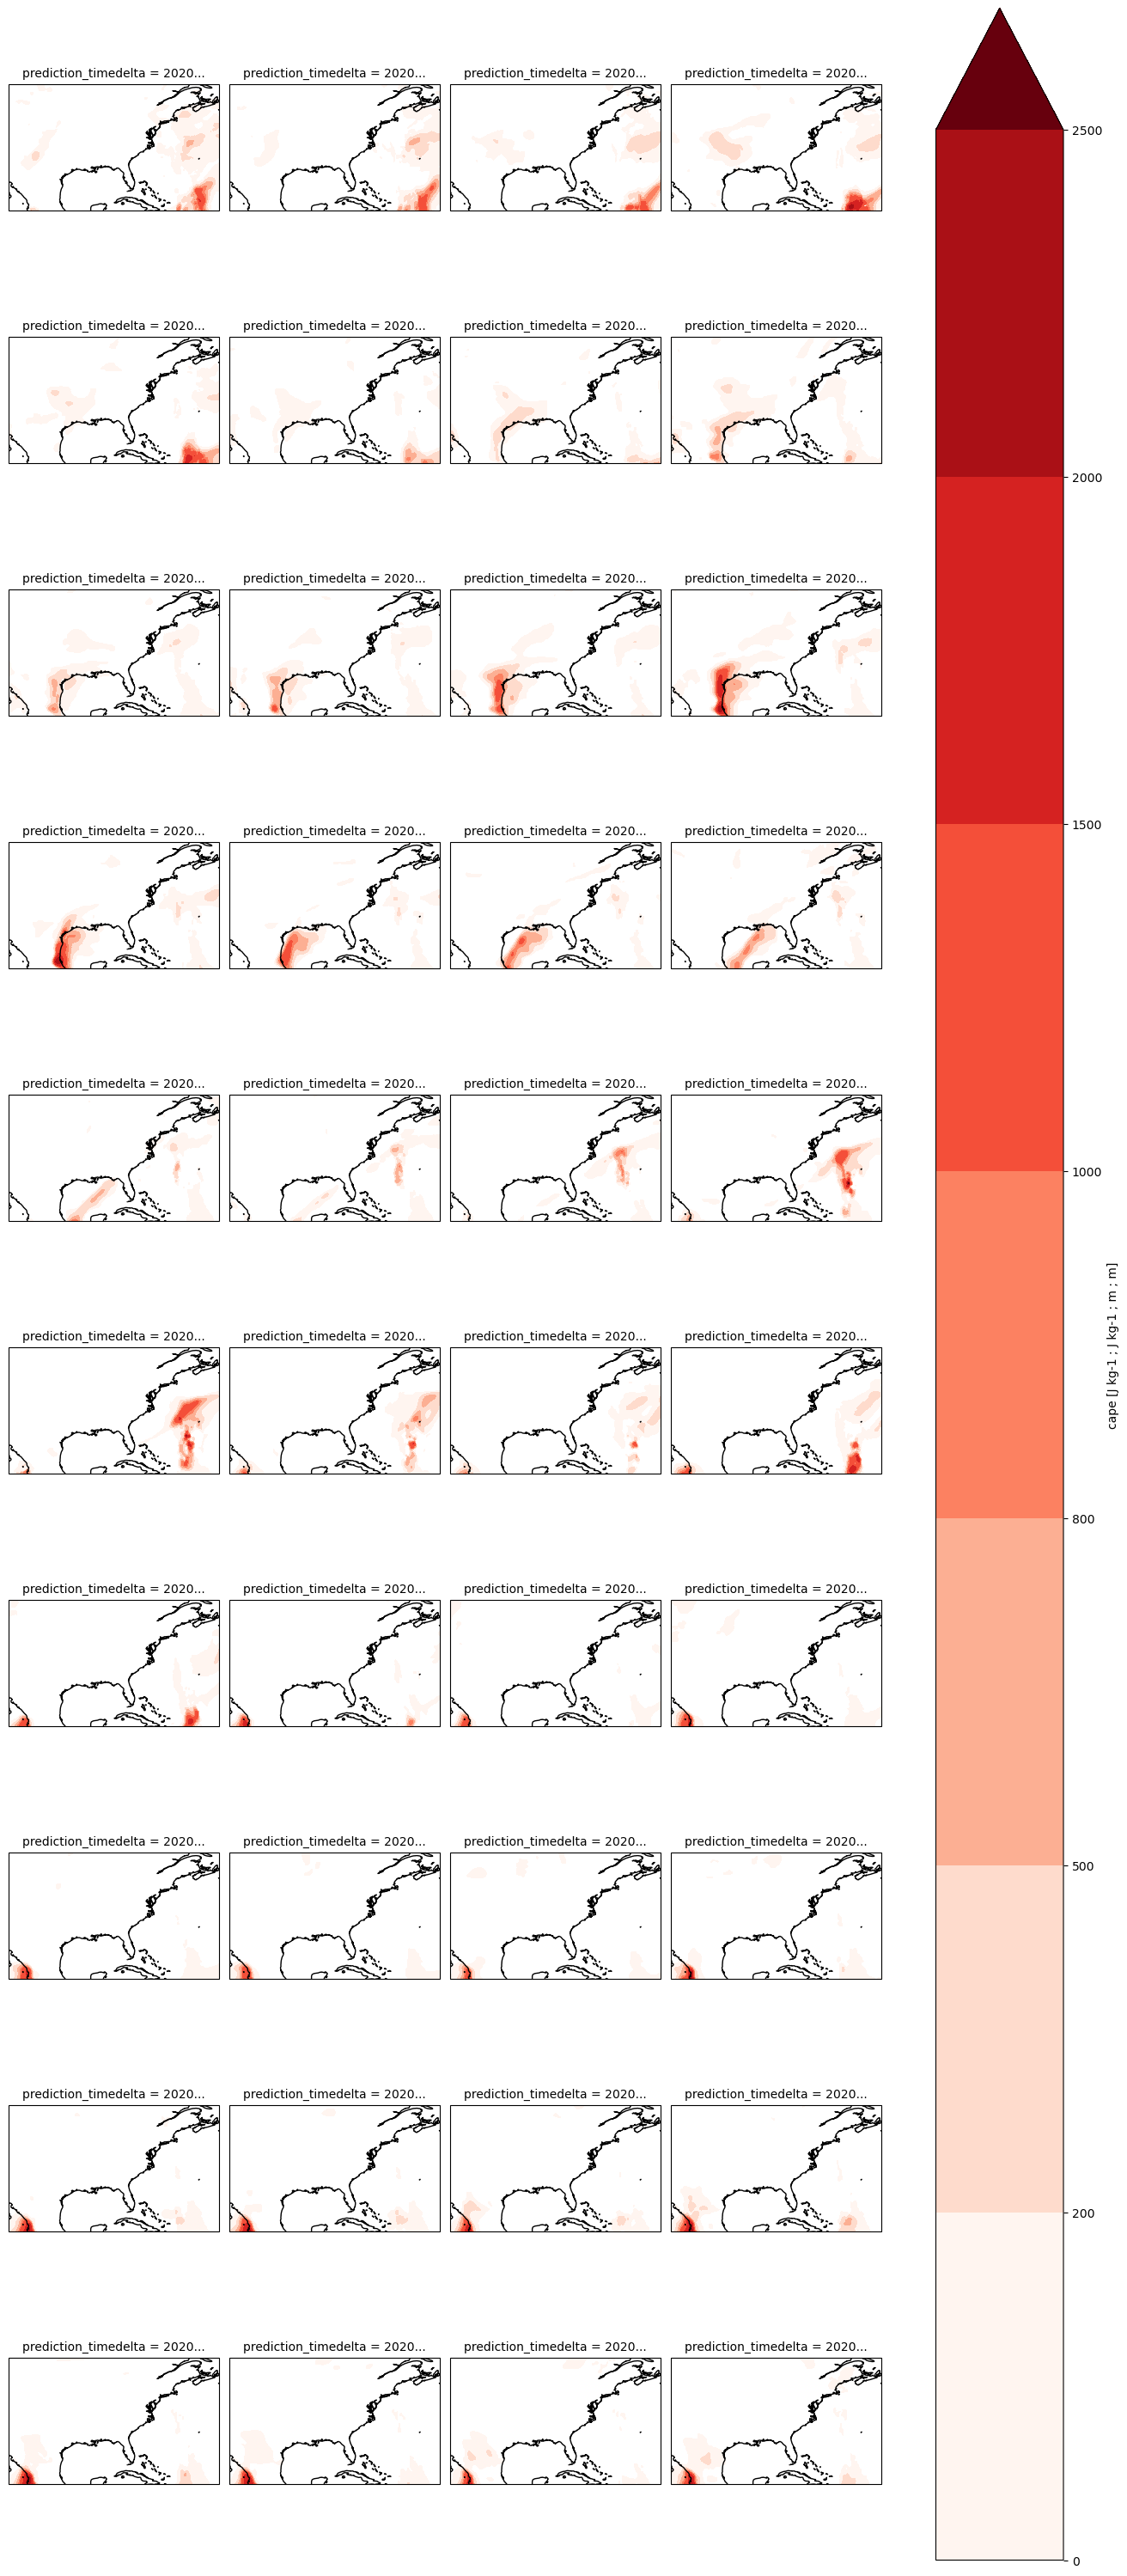

In [41]:
a=mod_params.cape.plot.contourf(transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
    col="prediction_timedelta", col_wrap=4,
    cmap='Reds',levels=[0,200,500,800,1000,1500,2000,2500],vmin=200,vmax=2500)
for ax in a.axes.flat:
    ax.coastlines()

In [1]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import copy
import wrf
import time
import cartopy.crs as ccrs
import datetime
import glob
import datetime as dt
import seaborn as sns
import metpy
from metpy.units import units
import argparse as ap
print('modules loaded')
##%
# parser = ap.ArgumentParser()
# #parser.add_argument('--model', type=str, required=True)
# parser.add_argument('--region', type=str, required=True)
# args = parser.parse_args()
nn=0#int(args.model)
event_ID=0#int(args.region)
print('settings loaded')
##%
figpath='/users/mfeldman/figs/'
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020/'

#EVENT SELECTION ERA5
if event_ID==0:
    ###USA
    year=2020; month=np.arange(3,10); 
    latslice=slice(20,50); lonslice=slice(250,300)
    lon_conv=False
    flag='USA'
elif event_ID==1:
    ###ARGENTINA
    year=2020; month=(9,10,11,12,1,2)
    latslice=slice(-40,-25); lonslice=slice(290,310)
    lon_conv=False
    flag='ARG'
elif event_ID==2:
    ###AUSTRALIA
    year=2020; month=(9,10,11,12,1,2)
    latslice=slice(-35,-20); lonslice=slice(140,155)
    lon_conv=False
    flag='AUS'
elif event_ID==3:
    ###CHINA
    year=2020; month=np.arange(4,10)
    latslice=slice(20,35); lonslice=slice(100,120)
    lon_conv=False
    flag='CHN'
elif event_ID==4:
    ###EUROPE
    year=2020; month=np.arange(4,10)
    latslice=slice(35,55); lonslice=slice(-10,30)
    lon_conv=True
    flag='EUR'

savepath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'

#%%
#FOURCASTNET

era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude')
if lon_conv:
    xr_era5.coords['longitude'] = (xr_era5.coords['longitude'] + 180) % 360 - 180
    xr_era5 = xr_era5.sortby(xr_era5.longitude)
xr_era5=xr_era5.sel(latitude=latslice,longitude=lonslice)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))
zsurf_c=xr_era5['geopotential_at_surface']
#LOADING FORECAST DATASET
models=['sfno','sfno-oper']
model=models[nn]
path='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/'
files=[]

for mon in month:
    mon=str(mon).zfill(2) 
    files+=sorted(glob.glob(path+'*2020.'+mon+'*h00m_*.nc')+glob.glob(path+'*2020.'+mon+'*h12m_*.nc'))

for file in files[:1]:
    xr_model=xr.open_dataset(file)
    strfind1=file.find('fcnet_')+len('fcnet_')
    strfind2=file.find('_max')
    init=file[strfind1:strfind2].replace('-','').replace('T','').replace('h','').replace('m','').replace('.','')
    init2=xr_model.time.values
    # xr_model=xr_model.rename({'lat':'latitude'})
    # xr_model=xr_model.rename({'lon':'longitude'})
    xr_model=xr_model.rename({'leadtime_hours':'prediction_timedelta'})
    if lon_conv:
        xr_model.coords['longitude'] = (xr_model.coords['longitude'] + 180) % 360 - 180
        xr_model = xr_model.sortby(xr_model.longitude)
    #xr_model=xr_model.squeeze(dim='history')
    xr_model=xr_model.sortby('latitude').sel(latitude=latslice,longitude=lonslice)
    plevel=[50,100,150,200,250,300,400,500,600,700,850,925,1000]
    ulevel = xr_model.u #xr_model['__xarray_dataarray_variable__'][:,8:21,:]
    vlevel = xr_model.v #['__xarray_dataarray_variable__'][:,21:34,:]
    zlevel = xr_model.z #['__xarray_dataarray_variable__'][:,34:47,:]
    tlevel = xr_model.t #['__xarray_dataarray_variable__'][:,47:60,:]
    rlevel = xr_model.r #['__xarray_dataarray_variable__'][:,60:73,:]
    psurf = xr_model.sp #['__xarray_dataarray_variable__'][:,5,:]
    tsurf = xr_model.t2m #['__xarray_dataarray_variable__'][:,4,:]
    usurf = xr_model.u10 #['__xarray_dataarray_variable__'][:,0,:]
    vsurf = xr_model.v10 #['__xarray_dataarray_variable__'][:,1,:]

    plevel_dim=np.ones([1,len(plevel),1,1])
    for n1 in range(len(plevel)):
        plevel_dim[0,n1,0,0]=plevel[n1]
    plevel_exp=(tlevel/tlevel)*plevel_dim
    
    dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
    qlevel=metpy.calc.specific_humidity_from_dewpoint(plevel_exp.values* units('hPa'), dplevel).magnitude
    


modules loaded
settings loaded


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


In [9]:


files=[]

for mon in month:
    mon=str(mon).zfill(2) 
    files+=sorted(glob.glob(path+'*2020.'+mon+'*00h00m_*.nc')+glob.glob(path+'*2020.'+mon+'*12h00m_*.nc'))

In [10]:
files

['/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.01-00h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.01-12h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.02-00h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.02-12h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.03-00h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.03-12h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020.03.04-00h00m_maxltd-240_timeres-6.nc',
 '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/AI-milton/Monika_4castnet_2020/fcnet_2020

In [ ]:
    #.to(units('kg/kg')#.magnitude

    # zsurf = zsurf_c.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=0)
    #zsurf=zsurf.sel(latitude=latslice,longitude=slice(250,300))
    
    zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
    zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
     
    zs=zsurf/9.81
    zl=zlevel/9.81

    #psurf=pmsl * (tsurf/ (tsurf - (zs) * 0.0065))**(-1)
    ps=psurf/100

    mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
    mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
    mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
    mod_inst=mod_inst.assign_coords(prediction_timedelta=psurf.prediction_timedelta.values)

    du_01=ulevel[:,10,:,:]-usurf; dv_01=vlevel[:,10,:,:]-vsurf
    du_03=ulevel[:,9,:,:]-usurf; dv_03=vlevel[:,9,:,:]-vsurf
    du_06=ulevel[:,7,:,:]-usurf; dv_06=vlevel[:,7,:,:]-vsurf
    
    bs_01=( du_01**2 + dv_01**2 )**0.5
    bs_03=( du_03**2 + dv_03**2 )**0.5
    bs_06=( du_06**2 + dv_06**2 )**0.5
    
    du_01=du_01.to_dataset(name='du_01')
    dv_01=dv_01.to_dataset(name='dv_01')
    bs_01=bs_01.to_dataset(name='bs_01')
    du_03=du_03.to_dataset(name='du_03')
    dv_03=dv_03.to_dataset(name='dv_03')
    bs_03=bs_03.to_dataset(name='bs_03')
    du_06=du_06.to_dataset(name='du_06')
    dv_06=dv_06.to_dataset(name='dv_06')
    bs_06=bs_06.to_dataset(name='bs_06')
    
    mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
    #mod_params=mod_params.squeeze(dim='level')
    mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
    mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
    mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
    mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
    q1level=copy.deepcopy(tlevel)
    q1level.data=qlevel
    mod_params['q500']=q1level.sel(level=500)
    mod_params['r500']=rlevel.sel(level=500)
    mod_params['t500']=tlevel.sel(level=500)
    mod_params['q925']=q1level.sel(level=925)
    mod_params['r925']=rlevel.sel(level=925)
    mod_params['t925']=tlevel.sel(level=925)
    mod_params = mod_params.squeeze()
    mod_params = mod_params.drop(['mcape_mcin_lcl_lfc','level'])
    
    
    mod_params.to_netcdf(savepath+flag+'_conv_'+model+'_'+init+'.nc')

In [12]:
q1level.shape

(1, 40, 13, 121, 201)